# Cross validation 3 folds

In [1]:
#on 4 qubits
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

import torch 
import torch_geometric
import pickle


from tqdm import tqdm
import networkx as nx

import random
from torch_geometric.loader import DataLoader
from random import shuffle

num_qubits = 8  # Replace with the actual number of qubits



import random


import os
from torch_geometric.data import DataLoader
from random import shuffle



from sklearn.model_selection import KFold

import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

/home/leonardo/anaconda3/envs/NK_P/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
start_dir = "/home/leonardo/MINISQ-datasets/data_engineering/data/processed/8_qubits"
graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
sample_graph = random.choice(graphs)
num_node_features = sample_graph.num_node_features
num_classes = len(set(graph.y for graph in graphs))


In [3]:
from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Training GCN

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

Fold 1


/home/leonardo/anaconda3/envs/NK_P/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1, Epoch 10, Train Loss: 1.7630454619725546, Train Acc: 0.22, Val Loss: 1.7639259000619252, Val Acc: 0.15833333333333333
Fold 1, Epoch 20, Train Loss: 1.7362624595562617, Train Acc: 0.23416666666666666, Val Loss: 1.7511309226353964, Val Acc: 0.19333333333333333
Fold 1, Epoch 30, Train Loss: 1.6931474069754282, Train Acc: 0.25, Val Loss: 1.716242351134618, Val Acc: 0.18333333333333332
Fold 1, Epoch 40, Train Loss: 1.6799003730217617, Train Acc: 0.25583333333333336, Val Loss: 1.696557225783666, Val Acc: 0.20166666666666666
Fold 1, Epoch 50, Train Loss: 1.6689838280280431, Train Acc: 0.26416666666666666, Val Loss: 1.6825199802716573, Val Acc: 0.215
Fold 1, Epoch 60, Train Loss: 1.6678746690352757, Train Acc: 0.26416666666666666, Val Loss: 1.679492070277532, Val Acc: 0.21833333333333332
Fold 1, Epoch 70, Train Loss: 1.6633872588475545, Train Acc: 0.2633333333333333, Val Loss: 1.6795954326788585, Val Acc: 0.22
Fold 1, Epoch 80, Train Loss: 1.6625184019406636, Train Acc: 0.2633333333333

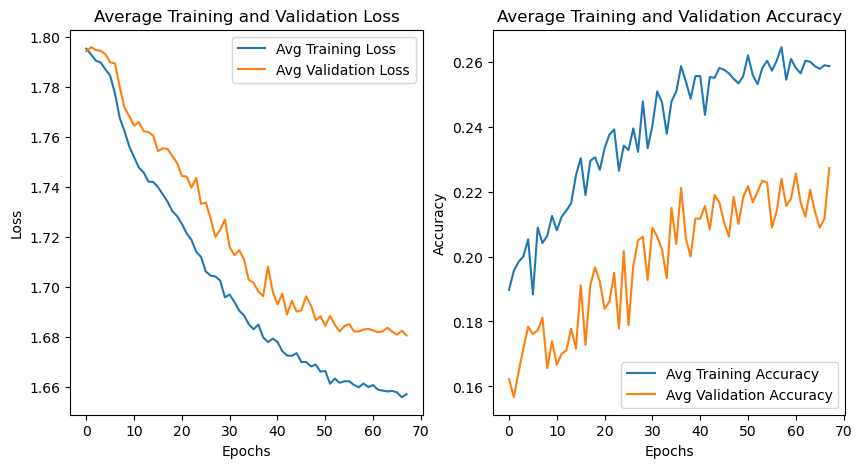

Model parameters saved to k_fold8qubits_GCN_final_model.pkl
Accuracies saved to k_fold/8qubits_GCN_final_accuracies.npy
Loaded Mean Training Accuracy: 0.25805555555555554
Loaded Mean Validation Accuracy: 0.24


In [5]:

# Train function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Test function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)


graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc':[],
    'best_train_acc': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GCN(hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > 30:
            print("Early stopping...")
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Avg Training Accuracy')
plt.plot(avg_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()

plt.show()




# Assuming fold_performance['train_acc'] and fold_performance['val_acc'] are lists of lists
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])

acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}


import pickle
import numpy as np

# Assuming num_qubits is defined
model_name = model.__class__.__name__  # Gets the class name of the model

# Filenames
acc_filename = f"k_fold/{num_qubits}qubits_{model_name}_final_accuracies.npy"
model_filename = f"k_fold{num_qubits}qubits_{model_name}_final_model.pkl"

# Save the model parameters
with open(model_filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model parameters saved to {model_filename}")

# Save accuracies to the .npy file
np.save(acc_filename, acc_data)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = np.load(acc_filename, allow_pickle=True).item()
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

# Training GCN v2

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [7]:
from torch.nn import Linear, BatchNorm1d
from torch.nn.functional import relu, dropout
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
import torch

class ImprovedGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(ImprovedGCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, num_classes) # Assuming 5 classes

    def forward(self, x, edge_index, batch):
        x = relu(self.bn1(self.conv1(x, edge_index)))
        x = relu(self.bn2(self.conv2(x, edge_index)))
        x = self.bn3(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)

        x = dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedGCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Fold 1
Fold 1, Epoch 10, Train Loss: 1.759234509865443, Train Acc: 0.2475, Val Loss: 1.7469205617904664, Val Acc: 0.15833333333333333
Fold 1, Epoch 20, Train Loss: 1.7353033989667892, Train Acc: 0.2425, Val Loss: 1.7263743241628011, Val Acc: 0.16
Fold 1, Epoch 30, Train Loss: 1.7440516432126363, Train Acc: 0.2708333333333333, Val Loss: 1.7293828030427296, Val Acc: 0.20166666666666666
Fold 1, Epoch 40, Train Loss: 1.723169818520546, Train Acc: 0.2675, Val Loss: 1.7292146503925323, Val Acc: 0.20833333333333334
Fold 1, Epoch 50, Train Loss: 1.718941115339597, Train Acc: 0.2841666666666667, Val Loss: 1.7226727724075317, Val Acc: 0.21333333333333335
Fold 1, Epoch 60, Train Loss: 1.7028559356927873, Train Acc: 0.2833333333333333, Val Loss: 1.715473759174347, Val Acc: 0.20166666666666666
Fold 1, Epoch 70, Train Loss: 1.7097061157226563, Train Acc: 0.2833333333333333, Val Loss: 1.7140769461790721, Val Acc: 0.21833333333333332
Fold 1, Epoch 80, Train Loss: 1.710791144768397, Train Acc: 0.2925, 

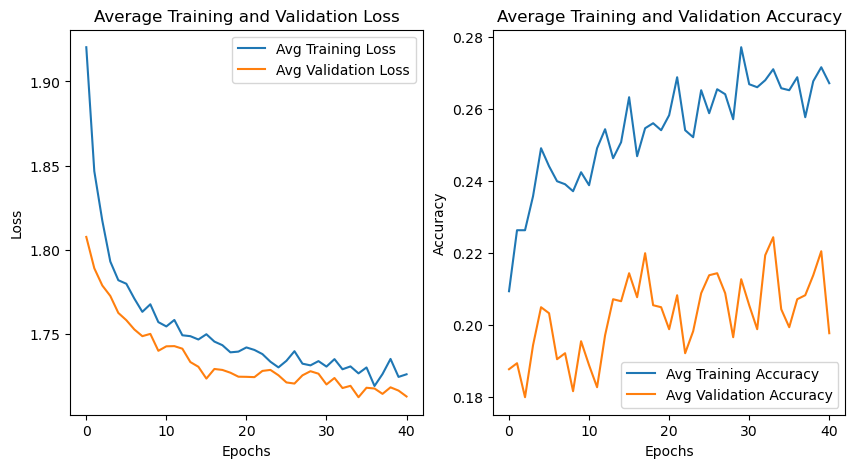

Model parameters saved to k_fold8qubits_ImprovedGCN_final_model.pkl
Accuracies saved to k_fold/8qubits_ImprovedGCN_final_accuracies.npy
Loaded Mean Training Accuracy: 0.26805555555555555
Loaded Mean Validation Accuracy: 0.24055555555555555


In [9]:
# Train function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Test function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)


graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc':[],
    'best_train_acc': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = ImprovedGCN(hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > 30:
            print("Early stopping...")
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Avg Training Accuracy')
plt.plot(avg_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()

plt.show()




# Assuming fold_performance['train_acc'] and fold_performance['val_acc'] are lists of lists
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])

acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}


import pickle
import numpy as np

# Assuming num_qubits is defined
model_name = model.__class__.__name__  # Gets the class name of the model

# Filenames
acc_filename = f"k_fold/{num_qubits}qubits_{model_name}_final_accuracies.npy"
model_filename = f"k_fold{num_qubits}qubits_{model_name}_final_model.pkl"

# Save the model parameters
with open(model_filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model parameters saved to {model_filename}")

# Save accuracies to the .npy file
np.save(acc_filename, acc_data)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = np.load(acc_filename, allow_pickle=True).item()
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

# Training GIN

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool

class GINModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GINModel, self).__init__()
        nn1 = torch.nn.Sequential(Linear(num_node_features, 64), torch.nn.ReLU(), Linear(64, 64))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(64)

        nn2 = torch.nn.Sequential(Linear(64, 64), torch.nn.ReLU(), Linear(64, 64))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(64)

        self.lin = Linear(64, num_classes)

    def forward(self, x, edge_index, batch):

        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)

        x = global_add_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=-1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GINModel(num_node_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

Fold 1
Fold 1, Epoch 10, Train Loss: 13.610094181696574, Train Acc: 0.23, Val Loss: 9.149437900384267, Val Acc: 0.18166666666666667
Fold 1, Epoch 20, Train Loss: 5.192285806934039, Train Acc: 0.22916666666666666, Val Loss: 3.448736908038457, Val Acc: 0.20166666666666666
Fold 1, Epoch 30, Train Loss: 3.694020716349284, Train Acc: 0.22333333333333333, Val Loss: 3.2940565327803295, Val Acc: 0.18833333333333332
Fold 1, Epoch 40, Train Loss: 3.376472798983256, Train Acc: 0.20333333333333334, Val Loss: 2.9232371946175895, Val Acc: 0.18333333333333332
Early stopping...
Completed Fold 1
Fold 2
Fold 2, Epoch 10, Train Loss: 15.346712068716686, Train Acc: 0.19333333333333333, Val Loss: 8.012549356619518, Val Acc: 0.21333333333333335
Fold 2, Epoch 20, Train Loss: 5.5281062662601474, Train Acc: 0.2275, Val Loss: 3.9230826596419015, Val Acc: 0.20166666666666666
Fold 2, Epoch 30, Train Loss: 3.6622659812370935, Train Acc: 0.21833333333333332, Val Loss: 2.365780462821325, Val Acc: 0.23333333333333334

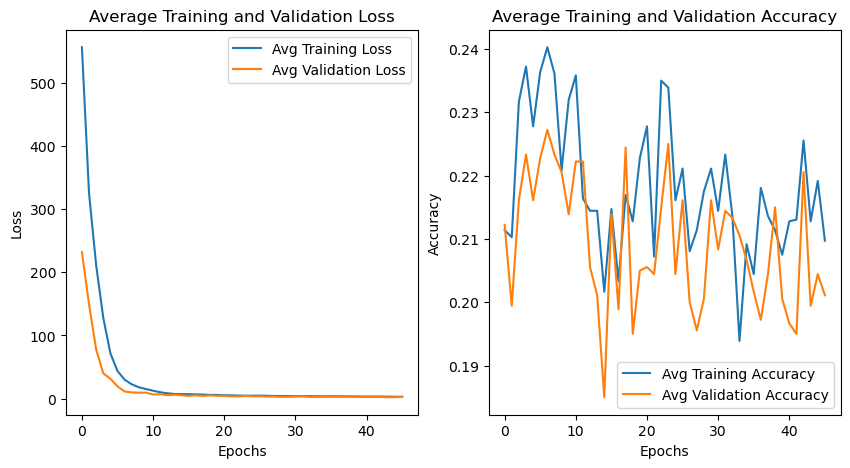

Model parameters saved to k_fold8qubits_GINModel_final_model.pkl
Accuracies saved to k_fold/8qubits_GINModel_final_accuracies.npy
Loaded Mean Training Accuracy: 0.21944444444444444
Loaded Mean Validation Accuracy: 0.1938888888888889


In [11]:

# Train function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Test function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)

# Load your dataset

graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GINModel(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    early_stopping_counter = 0

    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > 40:
            print("Early stopping...")
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Avg Training Accuracy')
plt.plot(avg_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()

plt.show()




# Assuming fold_performance['train_acc'] and fold_performance['val_acc'] are lists of lists
mean_train_acc = np.mean([component[-1] for component in fold_performance['train_acc']])
mean_val_acc = np.mean([component[-1] for component in fold_performance['val_acc']])

acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}


import pickle
import numpy as np

# Assuming num_qubits is defined

model_name = model.__class__.__name__  # Gets the class name of the model

# Filenames
acc_filename = f"k_fold/{num_qubits}qubits_{model_name}_final_accuracies.npy"
model_filename = f"k_fold{num_qubits}qubits_{model_name}_final_model.pkl"

# Save the model parameters
with open(model_filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model parameters saved to {model_filename}")

# Save accuracies to the .npy file
np.save(acc_filename, acc_data)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = np.load(acc_filename, allow_pickle=True).item()
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

# Training GAT

In [12]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 64, heads=8, dropout=0.6)
        self.conv2 = GATConv(64 * 8, 128, heads=1, concat=False, dropout=0.6)
        self.out = Linear(128, num_classes)

    def forward(self, x, edge_index, batch):

        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)

        return F.log_softmax(self.out(x), dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(num_node_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

Fold 1
Fold 1, Epoch 10, Train Loss: 1.756890943646431, Train Acc: 0.21333333333333335, Val Loss: 1.772016175587972, Val Acc: 0.19333333333333333
Fold 1, Epoch 20, Train Loss: 1.7491194327672324, Train Acc: 0.20916666666666667, Val Loss: 1.7635797659556072, Val Acc: 0.19333333333333333
Fold 1, Epoch 30, Train Loss: 1.751764025290807, Train Acc: 0.2275, Val Loss: 1.7719406068325043, Val Acc: 0.18833333333333332
Fold 1, Epoch 40, Train Loss: 1.7413113554318747, Train Acc: 0.20916666666666667, Val Loss: 1.7687858601411184, Val Acc: 0.175
Fold 1, Epoch 50, Train Loss: 1.740880611538887, Train Acc: 0.20583333333333334, Val Loss: 1.779483817021052, Val Acc: 0.18666666666666668
Fold 1, Epoch 60, Train Loss: 1.7359933267037073, Train Acc: 0.23583333333333334, Val Loss: 1.7686577618122101, Val Acc: 0.19833333333333333
Fold 1, Epoch 70, Train Loss: 1.7353495140870412, Train Acc: 0.22416666666666665, Val Loss: 1.769014980395635, Val Acc: 0.18333333333333332
Fold 1, Epoch 80, Train Loss: 1.7320839

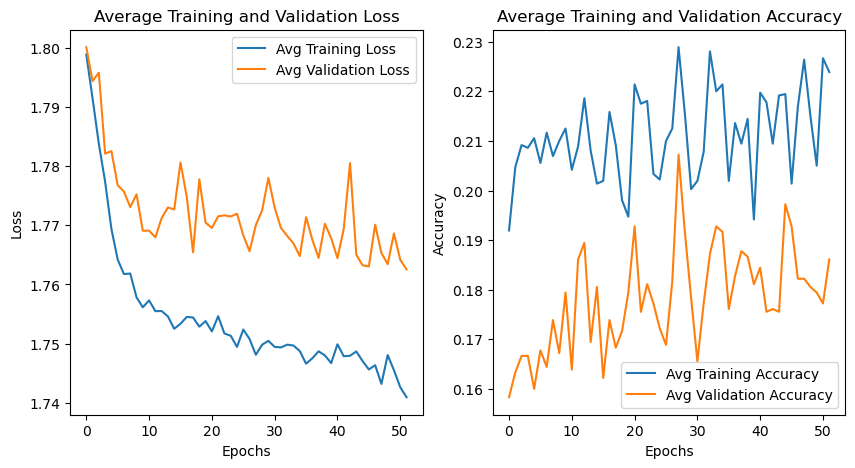

Model parameters saved to k_fold8qubits_GAT_final_model.pkl
Accuracies saved to k_fold/8qubits_GAT_final_accuracies.npy
Loaded Mean Training Accuracy: 0.24111111111111108
Loaded Mean Validation Accuracy: 0.21444444444444447


In [13]:
# Train function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Test function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)


graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc':[],
    'best_train_acc': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GAT(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > 30:
            print("Early stopping...")
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Avg Training Accuracy')
plt.plot(avg_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()

plt.show()




# Assuming fold_performance['train_acc'] and fold_performance['val_acc'] are lists of lists
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])

acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}


import pickle
import numpy as np

# Assuming num_qubits is defined

model_name = model.__class__.__name__  # Gets the class name of the model

# Filenames
acc_filename = f"k_fold/{num_qubits}qubits_{model_name}_final_accuracies.npy"
model_filename = f"k_fold{num_qubits}qubits_{model_name}_final_model.pkl"

# Save the model parameters
with open(model_filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model parameters saved to {model_filename}")

# Save accuracies to the .npy file
np.save(acc_filename, acc_data)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = np.load(acc_filename, allow_pickle=True).item()
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

# Training GraphSAGE

In [14]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 64)
        self.conv2 = SAGEConv(64, 128)
        self.out = Linear(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)

        return F.log_softmax(self.out(x), dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_node_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

Fold 1
Fold 1, Epoch 10, Train Loss: 1.7550751874844233, Train Acc: 0.21333333333333335, Val Loss: 1.7532462437947591, Val Acc: 0.19
Fold 1, Epoch 20, Train Loss: 1.7063260445992152, Train Acc: 0.23166666666666666, Val Loss: 1.721616510550181, Val Acc: 0.21166666666666667
Fold 1, Epoch 30, Train Loss: 1.683617619673411, Train Acc: 0.25666666666666665, Val Loss: 1.6952321430047352, Val Acc: 0.24333333333333335
Fold 1, Epoch 40, Train Loss: 1.6695913473765056, Train Acc: 0.25166666666666665, Val Loss: 1.6948208113511403, Val Acc: 0.23
Fold 1, Epoch 50, Train Loss: 1.661539015173912, Train Acc: 0.2725, Val Loss: 1.6889809449513753, Val Acc: 0.24333333333333335
Fold 1, Epoch 60, Train Loss: 1.6528389602899551, Train Acc: 0.2683333333333333, Val Loss: 1.6776316920916239, Val Acc: 0.24833333333333332
Early stopping...
Completed Fold 1
Fold 2
Fold 2, Epoch 10, Train Loss: 1.739877814054489, Train Acc: 0.22333333333333333, Val Loss: 1.7680667320887247, Val Acc: 0.17666666666666667
Fold 2, Epoc

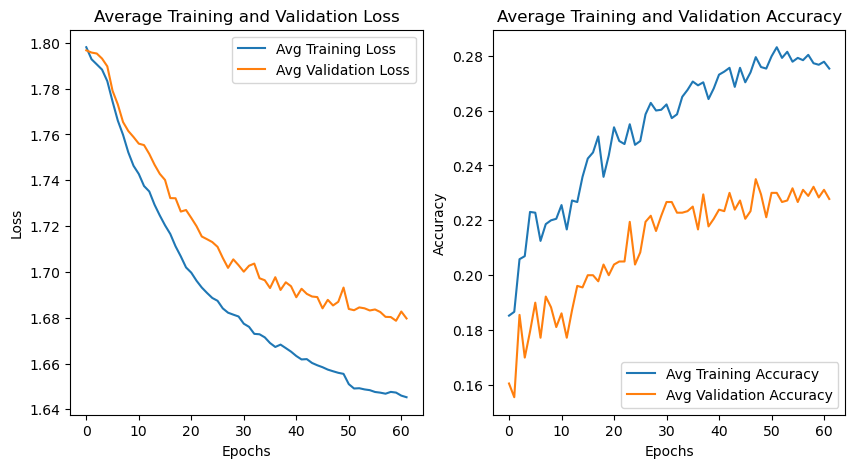

Model parameters saved to k_fold8qubits_GraphSAGE_final_model.pkl
Accuracies saved to k_fold/8qubits_GraphSAGE_final_accuracies.npy
Loaded Mean Training Accuracy: 0.2713888888888889
Loaded Mean Validation Accuracy: 0.2438888888888889


In [15]:
# Train function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Test function
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)


graphs = []
for graph in os.listdir(start_dir):
    graphs.append(torch.load(start_dir + "/" + graph))

# Shuffle the dataset
random.shuffle(graphs)

# Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc':[],
    'best_train_acc': []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GraphSAGE(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > 30:
            print("Early stopping...")
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Avg Training Accuracy')
plt.plot(avg_val_acc, label='Avg Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()

plt.show()




# Assuming fold_performance['train_acc'] and fold_performance['val_acc'] are lists of lists
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])

acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}


import pickle
import numpy as np

# Assuming num_qubits is defined

model_name = model.__class__.__name__  # Gets the class name of the model

# Filenames
acc_filename = f"k_fold/{num_qubits}qubits_{model_name}_final_accuracies.npy"
model_filename = f"k_fold{num_qubits}qubits_{model_name}_final_model.pkl"

# Save the model parameters
with open(model_filename, 'wb') as f:
    pickle.dump(model.state_dict(), f)
print(f"Model parameters saved to {model_filename}")

# Save accuracies to the .npy file
np.save(acc_filename, acc_data)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = np.load(acc_filename, allow_pickle=True).item()
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])